In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from typing import Optional, Sequence
from coba.experiments.results import CustomResult
import numpy as np

from coba import CobaRandom, Environments, RandomLearner, Experiment, VowpalSoftmaxLearner, VowpalBagLearner, VowpalEpsilonLearner
from coba import VowpalCoverLearner, VowpalRegcbLearner, VowpalSquarecbLearner, VowpalOffPolicyLearner, CorralLearner
from coba.environments import LambdaSimulation
from coba.experiments.tasks import SimpleEvaluation
from coba.primitives import Context, Action

# Run Simulation

In [11]:
from coba.learners.vowpal import VowpalRndLearner


class CustomEnvironment(LambdaSimulation):
    def __init__(self, n_interactions: Optional[int] = 1000):
        super().__init__(n_interactions, self.context, self.actions, self.rewards)
        self.r = CobaRandom(1)

    def actions(self, index: int, context: Context) -> Sequence[Action]:
        """
        actions: A function that should return all valid actions for a given index, context and random state.
        """
        return [0, 1]

    def context(self, index: int) -> Context:
        return {
            "feature_1": self.r.randoms(1)[0],
            "feature_2": self.r.randoms(1)[0],
            "feature_3": self.r.randoms(1)[0]
        }

    def rewards(self, index: int, context: Context, action: Action) -> float:
        # reward centered around 0.5, with feature_1 strongly positively correlating with the reward for the first action 
        # and feature_2 half as much negatively correlating
        reward_probabilities_for_actions = [
            0.5 
                + 1.0 * (context["feature_1"] - 0.5) 
                - 0.5 * (context["feature_2"] - 0.5),
            0.5
        ]
        
        reward_probabilities_for_actions = [min(1.0, max(0.0, prob)) for prob in reward_probabilities_for_actions]
        return np.random.binomial(1, reward_probabilities_for_actions[action])

environments = Environments([CustomEnvironment(5000)]).shuffle(n=4)
learners = [
    VowpalSoftmaxLearner(features=[1]),
    VowpalSoftmaxLearner(features=[1, 'x',]),
    VowpalSoftmaxLearner(features=[1, 'a',]),
    VowpalSoftmaxLearner(features=[1, 'ax',]),
    VowpalSoftmaxLearner(features=[1, 'x', 'a']),
    VowpalSoftmaxLearner(features=[1, 'x', 'a', 'ax']),
    VowpalSoftmaxLearner(features=[1, 'x', 'a', 'axx']),
    VowpalSoftmaxLearner(features=[1,'a','ax','axx'])
]
learners.append(RandomLearner())

result = Experiment(
    environments,
    learners,
    evaluation_task=SimpleEvaluation(record=['reward','probability','action','context'])
).run()
result.__class__ = CustomResult

2023-01-27 08:56:25 -- Processing chunk...
2023-01-27 08:56:25 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-01-27 08:56:25 --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2023-01-27 08:56:25 --   * Recording Learner 2 parameters... (0.0 seconds) (completed)
2023-01-27 08:56:25 --   * Recording Learner 3 parameters... (0.0 seconds) (completed)
2023-01-27 08:56:25 --   * Recording Learner 4 parameters... (0.0 seconds) (completed)
2023-01-27 08:56:25 --   * Recording Learner 5 parameters... (0.0 seconds) (completed)
2023-01-27 08:56:25 --   * Recording Learner 6 parameters... (0.0 seconds) (completed)
2023-01-27 08:56:25 --   * Recording Learner 7 parameters... (0.0 seconds) (completed)
2023-01-27 08:56:25 --   * Recording Learner 8 parameters... (0.0 seconds) (completed)
2023-01-27 08:56:25 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2023-01-27 08:56:25 --   * Peeking at Environment 0... (0.08 seconds) (completed)
2

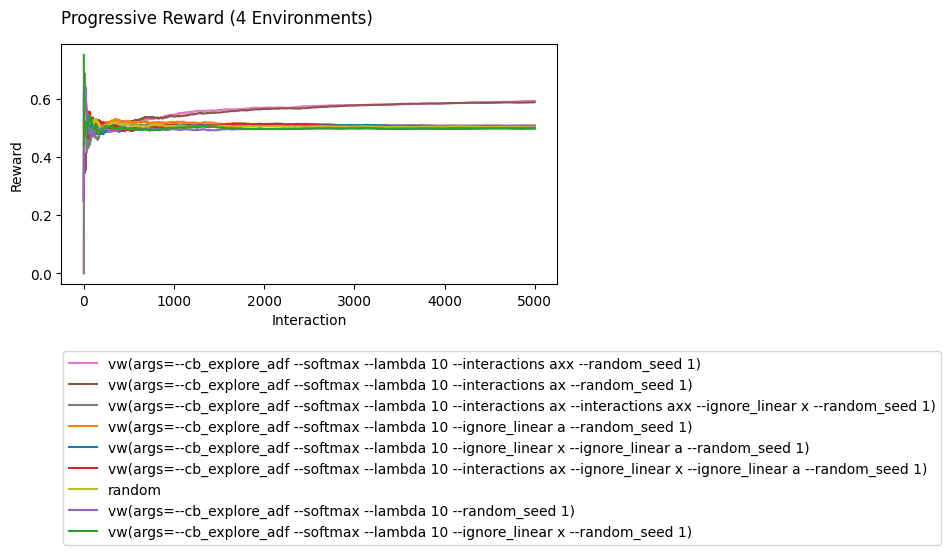

In [12]:
result.plot_learners()

array([[<AxesSubplot: title={'center': 'reward'}>]], dtype=object)

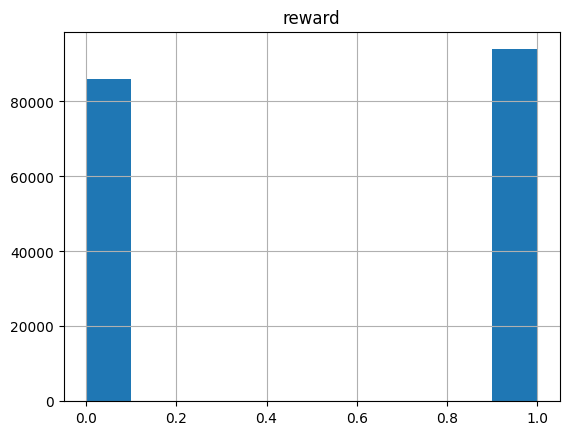

In [13]:
df = result.interactions.to_pandas()
df.hist(column='reward')

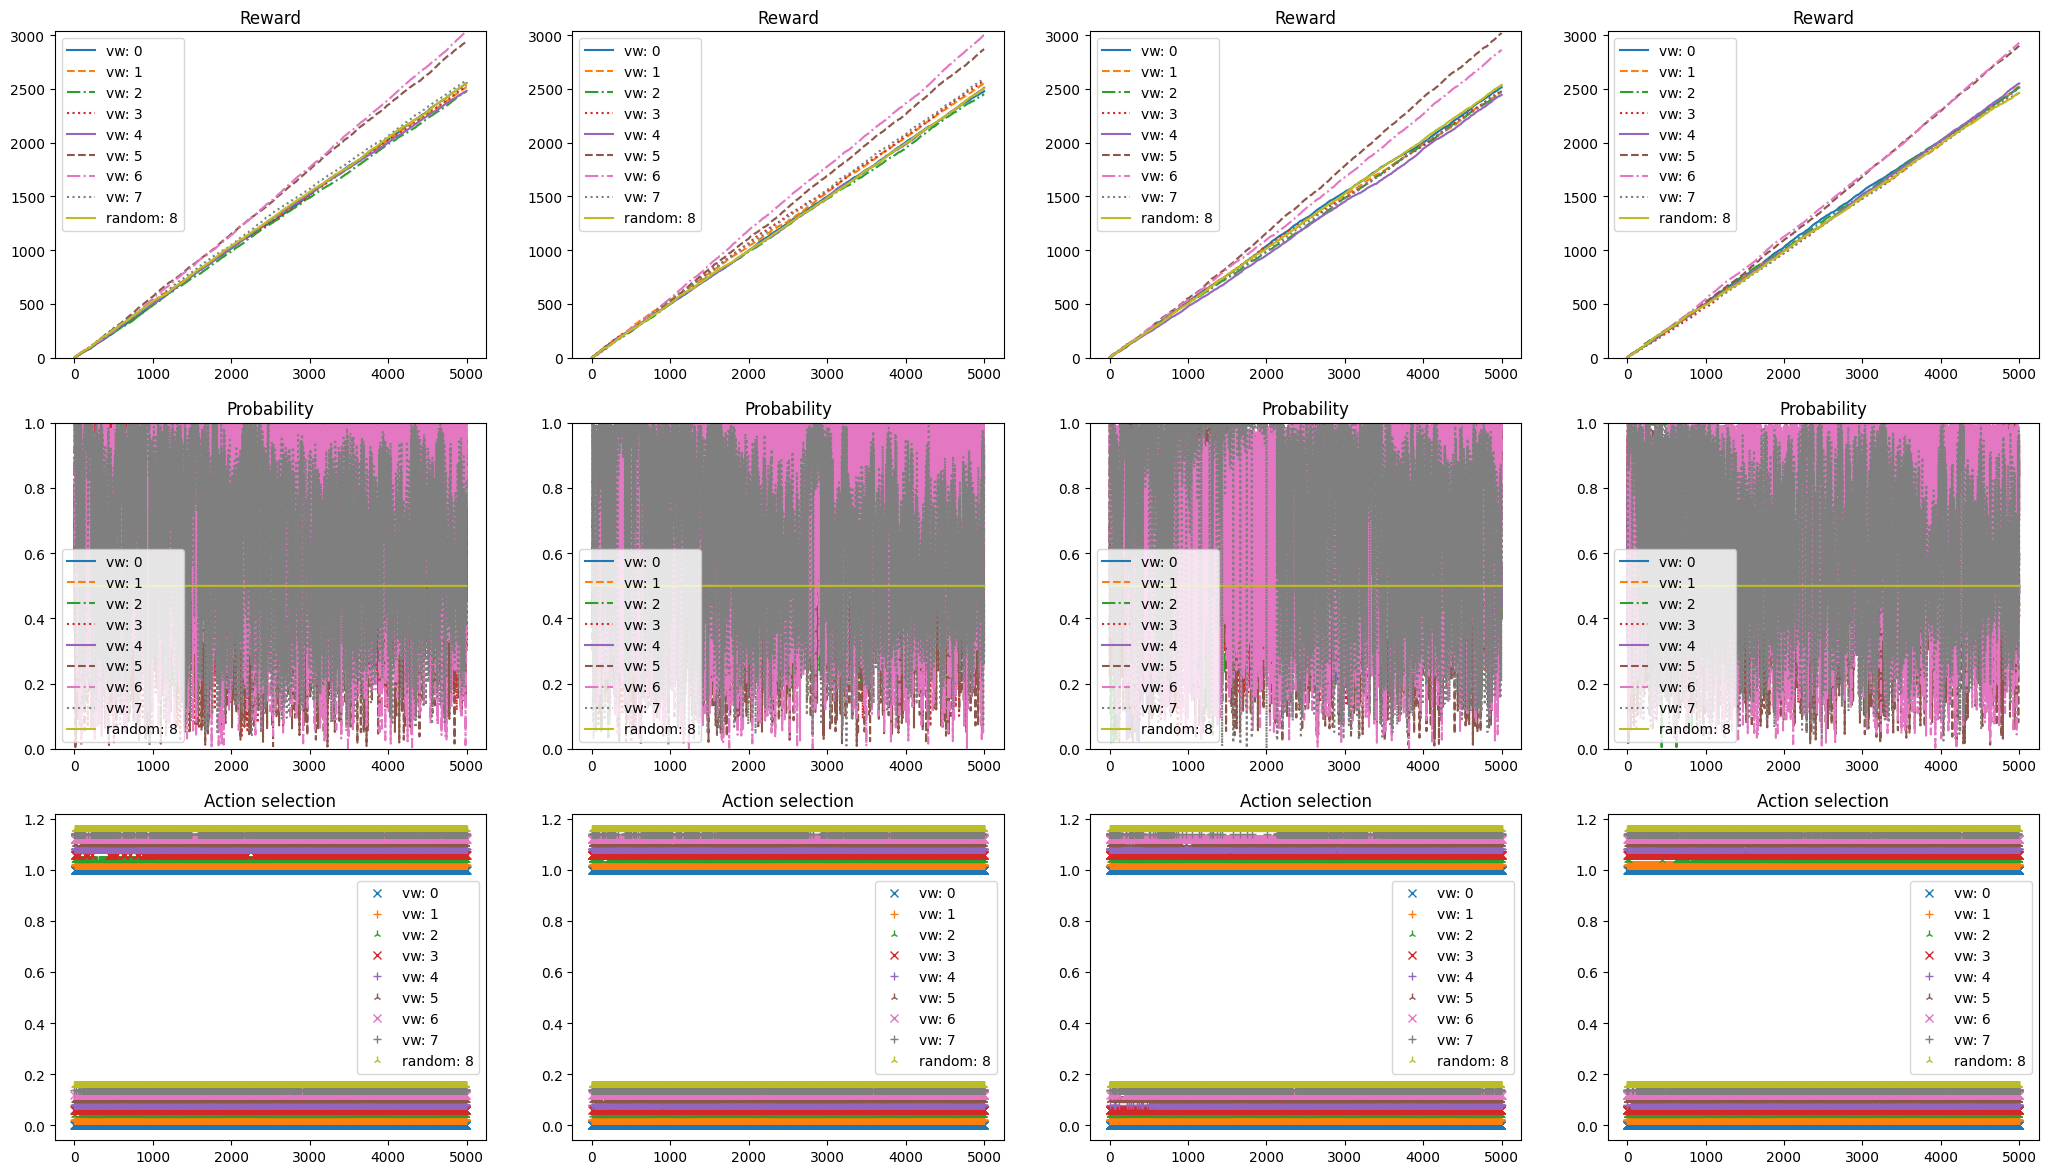

In [14]:
result.plot_overview()

In [17]:
result.eval_metrics()

,learners,reward,action,probability,environment_variance
learner_id,,,,,
6,vw: --cb_explore_adf --softmax --lambda 10 --i...,0.59165,0.45780,0.783178,0.000231
5,vw: --cb_explore_adf --softmax --lambda 10 --i...,0.58720,0.46915,0.740851,0.000171
7,vw: --cb_explore_adf --softmax --lambda 10 --i...,0.50780,0.41255,0.701571,0.000135
1,vw: --cb_explore_adf --softmax --lambda 10 --i...,0.50370,0.49120,0.500000,0.000041
0,vw: --cb_explore_adf --softmax --lambda 10 --i...,0.50340,0.49120,0.500000,0.000039
3,vw: --cb_explore_adf --softmax --lambda 10 --i...,0.50335,0.46665,0.593847,0.000108
8,random: N/A,0.50305,0.49120,0.500000,0.000062
4,vw: --cb_explore_adf --softmax --lambda 10 --r...,0.49980,0.52045,0.536680,0.000082
2,vw: --cb_explore_adf --softmax --lambda 10 --i...,0.49635,0.49350,0.560480,0.000027
